# Michael Omori
# Data Science ICS 691E HW1

I take the forest cover data set and run through two types of models:
1. Neural Networks
2. XGBoost

In [130]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
import pandas as pd
from sklearn import preprocessing
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras import optimizers
from keras.constraints import maxnorm
import pickle

# Function for sampling data

In [131]:
def sample_data(in_file, split):
    """Function basically equivalent to train_test sklearn, I just save mine to files and print some stuff"""
    df = pd.read_csv(in_file, header=None)
    df_sample = df.sample(frac=1)
    num_rows = len(df_sample)
    split_index = round(num_rows * (1 - split))
    df_sample[:split_index].to_csv("train_data.csv", header=None, index=True)
    df_sample[split_index:].to_csv("test_data.csv", header=None, index=True)
    print("Sampled the data and saved files")
    labels = df.iloc[:, -1]
    print("Original Data Labels:", Counter(labels).keys())  # equals to list(set(words))
    print("Original Data labels frequencies:", Counter(labels).values())  # counts the elements' frequency   

# Keras model wrapper for SKlearn

In [132]:
def create_model(num_features, h1_units=300, h2_units=100, h3_units=50, h1_act='relu', momentum=0.9, learn_rate=0.01,
                 decay=1e-6, drop_out=0.1):
    """Function to create a model for Sklearn wrapper grid search"""
    model = Sequential()
    model.add(Dropout(drop_out, input_shape=(num_features,)))
    model.add(Dense(units=h1_units, activation=h1_act, input_dim=num_features, kernel_constraint=maxnorm(3)))
    model.add(Dense(units=h2_units, activation=h1_act, input_dim=h1_units, kernel_constraint=maxnorm(3)))
    model.add(Dense(units=h3_units, activation=h1_act, input_dim=h2_units, kernel_constraint=maxnorm(3)))
    # num classes + 1 to account for 1-7, and 0 indexing
    model.add(Dense(units=8, activation='softmax'))

    sgd = optimizers.SGD(lr=learn_rate, decay=decay, momentum=momentum, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

# Sample the Data

In [133]:
seed = 7
np.random.seed(seed)

sample_data("covtype.data/covtype.csv", 0.2)

Sampled the data and saved files
Original Data Labels: dict_keys([5, 2, 1, 7, 3, 6, 4])
Original Data labels frequencies: dict_values([9493, 283301, 211840, 20510, 35754, 17367, 2747])


# Split into train and test

In [134]:
# Use a dummy class 0, because of the categorical indexing at 0, while data classes are from 1-7
fn = "train_data.csv"
fn_test = "test_data.csv"

df = pd.read_csv(fn, header=None)
x_train = df.values[:, 1:-1]
num_features = len(x_train[0])
# Features have large range, so scaling helps
x_train_scaled = preprocessing.scale(x_train)
y_train = df.values[:, -1]
categorical_labels = to_categorical(y_train, num_classes=8)

df_test = pd.read_csv(fn_test, header=None)
x_test = df_test.values[:, 1:-1]
x_test_scaled = preprocessing.scale(x_test)
y_test = df_test.values[:, -1]
categorical_labels_test = to_categorical(y_test, num_classes=8)

C:\Users\Michael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# Class Distribution

Training data length: 464810
Training data labels: dict_keys([3, 1, 2, 6, 5, 7, 4])
Training data labels counts: dict_values([28566, 169402, 226715, 13867, 7608, 16422, 2230])
Test data length: 116202
Training data labels: dict_keys([7, 1, 6, 2, 3, 5, 4])
Training data labels counts: dict_values([4088, 42438, 3500, 56586, 7188, 1885, 517])


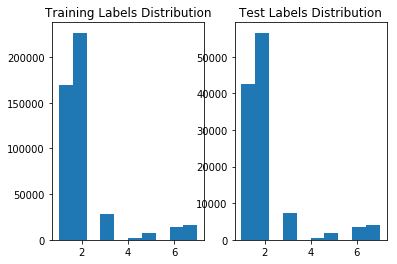

In [135]:
# Ensure equal class distribution for train and test
print("Training data length:", len(x_train))
print("Training data labels:", Counter(y_train).keys())  # equals to list(set(words))
print("Training data labels counts:", Counter(y_train).values())  # counts the elements' frequency

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train)
ax1.set_title("Training Labels Distribution")

print("Test data length:", len(x_test))
print("Training data labels:", Counter(y_test).keys())  # equals to list(set(words))
print("Training data labels counts:", Counter(y_test).values())  # counts the elements' frequency

ax2.hist(y_test)
ax2.set_title("Test Labels Distribution")
plt.show()

# Parameters for Grid Search

In [136]:
# Parameters for Grid Search
h1_units = 500
h2_units = 100
h3_units = 50
h1_act = ['relu', 'tanh']
momentum = [0.2, 0.4, 0.6, 0.8]
learn_rate = [0.001, 0.01, 0.01, 0.2, 0.3]
drop_out = [elem / 10 for elem in range(5)]
decay = 1e-6

best_model = None
best_validation_score = 0
best_history = None

# Custom grid search code
Tune learning rate and batch size after other parameters.
Best model was tanh width 0.8 momentum.
Takes some time, this one just goes through different activation functions and momentums.
Choose the one with best validation loss.

In [137]:
for act in h1_act:
    for m in momentum[2:]:
            print("Training new model")
            model = create_model(num_features, h1_units, h2_units, h3_units, act, m, 0.01, decay, 0)
            history = model.fit(x_train_scaled, categorical_labels, epochs=5, batch_size=128,
                                validation_split=0.2, verbose=0)
            score = max(history.history['val_acc'])
            if score > best_validation_score:
                print("New best model", act, m)
                print("Score", score)
                best_validation_score = score
                best_model = model
                best_history = history

model_fn = "nn_grid2.h5"
best_model.save(model_fn)

Training new model
New best model relu 0.6
Score 0.8128159893225614
Training new model
New best model relu 0.8
Score 0.8211204578150637
Training new model
Training new model
New best model tanh 0.8
Score 0.8487661625205828


# Fit and save a neural network model with more epochs
I chose a batch size of 128 because its a factor of two, and it's on the larger side so the training doesn't take too long.
I also tried some other models, but didn't save them, just took their best parameters.
The alpha value of 0.01 is on the larger size, but I use some decay to lower it during training.
3 layers to keep it simple, with decreasing amount of nodes.
Momentum to increase training convergence.
Didn't use dropout because overfitting didn't occur.

In [138]:
model = create_model(num_features, 500, 100, 50, 'tanh', 0.9, 0.01, decay, 0)
history = model.fit(x_train_scaled, categorical_labels, epochs=100, batch_size=128,
                    validation_split=0.2, verbose=1)

model_fn = "nn_100epochs_0.1dropout.h5"
model.save(model_fn)
print("Saved model")

with open('history3.pickle', 'wb') as f:
    pickle.dump(history.history, f)
    history = history.history

Train on 371848 samples, validate on 92962 samples
Epoch 1/100
371848/371848 [==============================] - 10s 28us/step - loss: 0.5776 - acc: 0.7548 - val_loss: 0.5007 - val_acc: 0.7843
Epoch 2/100
371848/371848 [==============================] - 10s 28us/step - loss: 0.4482 - acc: 0.8114 - val_loss: 0.4111 - val_acc: 0.8295
Epoch 3/100
371848/371848 [==============================] - 11s 28us/step - loss: 0.3850 - acc: 0.8407 - val_loss: 0.3654 - val_acc: 0.8510
Epoch 4/100
371848/371848 [==============================] - 11s 30us/step - loss: 0.3431 - acc: 0.8598 - val_loss: 0.3280 - val_acc: 0.8670
Epoch 5/100
371848/371848 [==============================] - 10s 28us/step - loss: 0.3140 - acc: 0.8722 - val_loss: 0.3138 - val_acc: 0.8713
Epoch 6/100
371848/371848 [==============================] - 10s 27us/step - loss: 0.2918 - acc: 0.8816 - val_loss: 0.2882 - val_acc: 0.8817
Epoch 7/100
371848/371848 [==============================] - 11s 28us/step - loss: 0.2736 - acc: 0.8893

# Load a saved model

In [139]:
try:
    model = load_model("nn_100epochs_0.1dropout.h5")
    with open('history3.pickle', 'rb') as f:
        history = pickle.load(f)
except:
    print("Model not found")

# Test the model

In [140]:
# Accuracy of 95% on the test data, slightly lower than the training accuracy which is to be expected.
# Not significantly lower, which suggests that the model has yet to overfit the training data.
loss_and_metrics = model.evaluate(x_test_scaled, categorical_labels_test, batch_size=32)
print("Loss and metrics", loss_and_metrics)

116202/116202 [==============================] - 2s 21us/step
Loss and metrics [0.13855911528231318, 0.949037021738008]


# Plot the losses

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


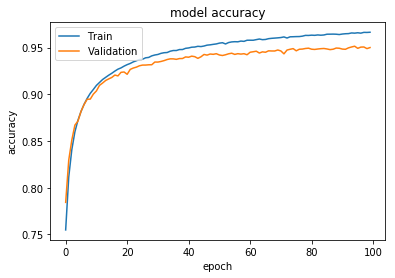

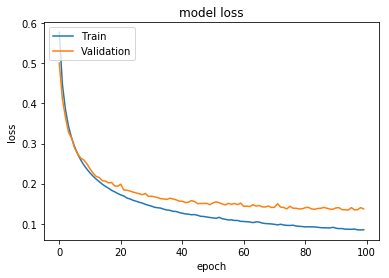

In [141]:

# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# XGBoost

In [142]:
import xgboost as xgb

In [143]:
# Don't use one hot encoding

split = round(0.2 * len(x_train_scaled))
x_val = x_train_scaled[:split]
y_val = y_train[:split]
x_train2 = x_train_scaled[split:]
y_train2 = y_train[split:]

dtrain = xgb.DMatrix(x_train2, label=y_train2)
dtest = xgb.DMatrix(x_test_scaled)

param = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'objective': 'multi:softprob'}
param['nthread'] = 4
param['eval_metric'] = 'mlogloss'
param['num_class'] = 8

dval = xgb.DMatrix(x_val, label=y_val)
evallist = [(dval, 'eval'), (dtrain, 'train')]

num_round = 100

# Training and testing

In [144]:
bst = xgb.train(param, dtrain, num_round, evallist)

bst.save_model('xgboost.model')

[0]	eval-mlogloss:1.82339	train-mlogloss:1.82123
[1]	eval-mlogloss:1.63473	train-mlogloss:1.6311
[2]	eval-mlogloss:1.48514	train-mlogloss:1.48006
[3]	eval-mlogloss:1.36194	train-mlogloss:1.35561
[4]	eval-mlogloss:1.25843	train-mlogloss:1.25087
[5]	eval-mlogloss:1.16842	train-mlogloss:1.15979
[6]	eval-mlogloss:1.09037	train-mlogloss:1.08091
[7]	eval-mlogloss:1.0217	train-mlogloss:1.01147
[8]	eval-mlogloss:0.960677	train-mlogloss:0.949536
[9]	eval-mlogloss:0.906451	train-mlogloss:0.894549
[10]	eval-mlogloss:0.856952	train-mlogloss:0.844224
[11]	eval-mlogloss:0.812479	train-mlogloss:0.799006
[12]	eval-mlogloss:0.772254	train-mlogloss:0.758064
[13]	eval-mlogloss:0.736094	train-mlogloss:0.721224
[14]	eval-mlogloss:0.703138	train-mlogloss:0.687635
[15]	eval-mlogloss:0.673723	train-mlogloss:0.657544
[16]	eval-mlogloss:0.646658	train-mlogloss:0.629899
[17]	eval-mlogloss:0.621968	train-mlogloss:0.604644
[18]	eval-mlogloss:0.599507	train-mlogloss:0.581755
[19]	eval-mlogloss:0.579027	train-mloglo

In [145]:
# make predictions for test data
bst = xgb.Booster({'nthread': 4})  # init model
try:
    bst.load_model('xgboost.model')  # load data
except:
    print("couldn't load model")
y_pred = bst.predict(dtest)

In [146]:
predictions = []
true = list(y_test)
for i in range(len(y_pred)):
    predictions.append(np.argmax(y_pred[i]))

In [147]:
# evaluate predictions
accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == true[i]:
        accuracy += 1
print(accuracy / len(predictions))

0.8973511643517323


Results are good, not as good as neural network, but I didn't fine tune the parameters

# Feature Importance

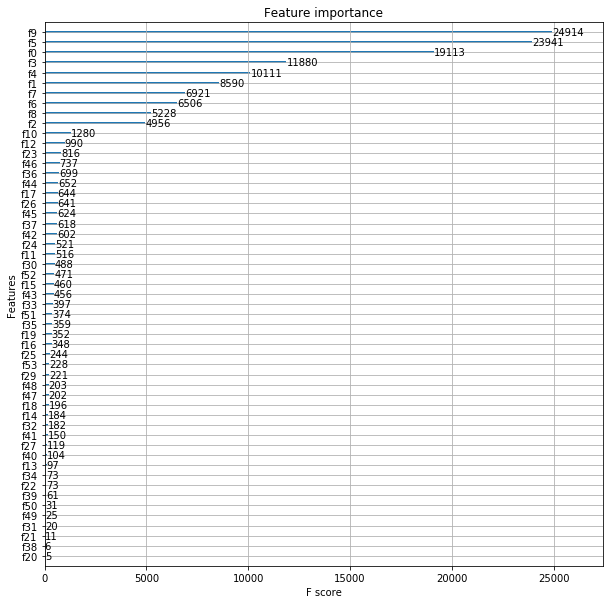

In [148]:
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(10, 10)

In [149]:
df = pd.read_excel("features.xlsx")
l = list(df.columns.values)
features = {}
for i in range(len(l)):
    features["f" + str(i)] = l[i]

In [150]:
best = [9, 5, 0, 3, 4]
worst = [20, 38, 21, 31, 49]
print("5 Best features")
for b in best:
    print(features["f" + str(b)])
print("\n5 Worst features")
for w in worst:
    print(features["f" + str(w)])

5 Best features
Horizontal_Distance_To_Fire_Points
Horizontal_Distance_To_Roadways
Elevation
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology

5 Worst features
Soil_Type7
Soil_Type25
Soil_Type8
Soil_Type18
Soil_Type36


# Summary
The neural network performed slightly better than XGBoost (95% vs 90% accuracy). But this might be partly because I spent more time fine-tuning the neural network.

Class distributions were heavily skewed and I tried to ensure that the training set distribution represented the test set distribution. I used mostly standard parameter values.

In order to improve what I did, I would tune the parameters more, use multiple validation sets, consider plotting the various variables and distributions, and maybe incorporate some pre-processing. I would also train to more epochs until overfitting occurs, then apply regualrization or drop out.

The most interesting results are probably from the feature importance, in which we see something intuitive like elevation and some maybe less intuitive things for me at least such as horizontal distance to fire points and roadways.